In [17]:
import os, sys

# Get the absolute path of the notebook's directory
notebook_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

# Add the parent directory to sys.path so we can import modules
sys.path.append(parent_dir)

# Verify the path
print(f"Added to sys.path: {parent_dir}")

# Add it to sys.path
sys.path.append(parent_dir)

from FlashOperation.Refrig2DrumHeatExConstrDummy import Refrig2DrumConstraintHeatExConstDummy
from module import *

Added to sys.path: /Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen


In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [19]:
import numpy as np
flash_1_range = np.linspace(-1, 1, 20)
flash_2_range = np.linspace(-1, 1, 20)

assSim = Refrig2DrumConstraintHeatExConstDummy(AspenFile = "./FlashOperation/FlashOperation.bkp", 
                                   wdpath = "./FlashOperation", 
                                   visibility=False,
                                   Penalty=1e4
                                   )

data = []
for flash_1 in flash_1_range:
    for flash_2 in flash_2_range:
        x_unflat = assSim.unflatten_params([flash_1, flash_2])
        data.append([flash_1, flash_2, assSim.run_obj(x_unflat)])
data = np.array(data)

⚠️ Dummy Mode: Skipping Aspen simulation initialization.


In [20]:
import numpy as np
flash_1_range = np.linspace(-1, 1, 100)
flash_2_range = np.linspace(-1, 1, 100)


data_big = []
for flash_1 in flash_1_range:
    for flash_2 in flash_2_range:
        x_unflat = assSim.unflatten_params([flash_1, flash_2])
        data_big.append([flash_1, flash_2, assSim.run_obj(x_unflat)])
data_big = np.array(data_big)

In [21]:
import numpy as np
flash_1_range = np.linspace(-1, 1, 5)
flash_2_range = np.linspace(-1, 1, 5)


data_small = []
for flash_1 in flash_1_range:
    for flash_2 in flash_2_range:
        x_unflat = assSim.unflatten_params([flash_1, flash_2])
        data_small.append([flash_1, flash_2, assSim.run_obj(x_unflat)])
data_small = np.array(data_small)

In [30]:
import torch
import numpy as np

def optimize_surrogate_model(
    model, old_dataset, new_dataset, assSim, 
    optim_steps=40, N_s=5, lr=0.001, merge_interval=10,
    x_init=torch.tensor([0.9, -0.9], dtype=torch.float32, requires_grad=True)
):
    """
    Performs online optimization using a surrogate model.

    Args:
    - model: Neural network model (MLP instance)
    - old_dataset (OldDataSet): Historical dataset
    - new_dataset (NewDataSet): New data storage
    - assSim: Object with run_obj() function for objective evaluation
    - optim_steps (int): Number of optimization steps
    - N_s (int): Number of local samples per step
    - lr (float): Learning rate for x updates
    - merge_interval (int): Steps after which new data merges with old dataset

    Returns:
    - x_path (list): History of `x` points explored
    - y_path (list): Corresponding objective function values
    """

    # **Initialize Optimization Variables** 
    optimizer = torch.optim.Adam([x_init], lr=lr)

    x_path, y_path = [], []

    # **Optimization Loop**
    for step in range(optim_steps):
        print(f"\nStep {step + 1}/{optim_steps}")

        new_samples = []
        
        # Generate new local samples
        for _ in range(N_s):
            x = x_init.detach() + torch.randn_like(x_init) * 0.1
            y = assSim.run_obj(assSim.unflatten_params(x))
            new_samples.append(torch.cat((x, y.unsqueeze(0))).numpy())

        # Add new samples to `NewDataSet`
        new_dataset.add_samples(np.stack(new_samples))

        # Train surrogate model
        model = train_model(model, old_dataset, new_dataset)

        # Merge new samples into old dataset every `merge_interval` steps
        if step % merge_interval == 0:
            old_dataset.merge(new_dataset.data)
            new_dataset.clear()

        # **Select Best Sample from Generated Samples**
        new_samples_array = np.stack(new_samples)
        best_sample_idx = np.argmin(new_samples_array[:, -1])  # Minimize objective function
        x_init = torch.tensor(new_samples_array[best_sample_idx][:2], dtype=torch.float32, requires_grad=True)

        # **Track Optimization Path**
        x_path.append(x_init.tolist())
        y_path.append(new_samples_array[best_sample_idx, -1])

        # **Gradient-Based Update Using Surrogate Model**
        optimizer.zero_grad()
        y_pred = model(x_init)
        grad = torch.autograd.grad(y_pred, x_init)[0]
        optimizer.step()

        print(f"Updated x: {x_init.tolist()}, Function Value: {y_path[-1]}, Gradient: {grad.tolist()}")

    return x_path, y_path


In [23]:
# **Initialize Model & Datasets**
old_dataset = OldDataSet(data, k=10)
new_dataset = NewDataSet(k=10)
model = MLP(2, [5, 5, 5], 1)

# **Run Optimization**
x_path, y_path = optimize_surrogate_model(model, old_dataset, new_dataset, assSim, optim_steps=40, N_s=5, lr=0.001, merge_interval=10)


Step 1/40
Epoch 0: Total Loss=6.1124
Epoch 1: Total Loss=7.1633
Epoch 2: Total Loss=6.2287
Epoch 3: Total Loss=5.8909
Epoch 4: Total Loss=6.9220
Epoch 5: Total Loss=6.0147
Epoch 6: Total Loss=5.6922
Epoch 7: Total Loss=6.7033
Epoch 8: Total Loss=5.8155
Epoch 9: Total Loss=5.5083
Updated x: [0.9160996675491333, -0.7360634207725525], Function Value: 1.3810279369354248, Gradient: [0.024571888148784637, -0.04308870807290077]

Step 2/40
Epoch 0: Total Loss=4.1546
Epoch 1: Total Loss=3.9496
Epoch 2: Total Loss=3.4490
Epoch 3: Total Loss=4.0270
Epoch 4: Total Loss=3.8213
Epoch 5: Total Loss=3.3392
Epoch 6: Total Loss=3.8946
Epoch 7: Total Loss=3.6885
Epoch 8: Total Loss=3.2231
Epoch 9: Total Loss=3.7545
Updated x: [0.8062655925750732, -0.7122756838798523], Function Value: 1.1574008464813232, Gradient: [0.05587337538599968, -0.17038433253765106]

Step 3/40
Epoch 0: Total Loss=0.3154
Epoch 1: Total Loss=0.2205
Epoch 2: Total Loss=0.3433
Epoch 3: Total Loss=0.2856
Epoch 4: Total Loss=0.3104
Epo

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of N_s values to test
N_s_values = np.arange(1, 10, 2)  # Testing N_s in increments of 2
optim_steps = 40

# Dictionary to store results
results = {}

# Run optimization for each N_s and store the results
for N_s in N_s_values:
    # Initialize datasets and model
    old_dataset = OldDataSet(data, k=10)
    new_dataset = NewDataSet(k=10)
    model = MLP(2, [5, 5, 5], 1)
    
    # Run optimization
    x_path, y_path = optimize_surrogate_model(model, old_dataset, new_dataset, assSim, optim_steps=optim_steps, N_s=N_s, lr=0.001, merge_interval=10)
    
    # Store y_path for plotting
    results[N_s] = y_path



Step 1/40
Epoch 0: Total Loss=4.9762
Epoch 1: Total Loss=4.9534
Epoch 2: Total Loss=4.9283
Epoch 3: Total Loss=4.9048
Epoch 4: Total Loss=4.8841
Epoch 5: Total Loss=4.8572
Epoch 6: Total Loss=4.8312
Epoch 7: Total Loss=4.8038
Epoch 8: Total Loss=4.7777
Epoch 9: Total Loss=4.7485
Updated x: [0.8997719883918762, -0.8655495047569275], Function Value: 1.5587656497955322, Gradient: [-0.015557564795017242, -0.1180882379412651]

Step 2/40
Epoch 0: Total Loss=4.1325
Epoch 1: Total Loss=4.1050
Epoch 2: Total Loss=4.0759
Epoch 3: Total Loss=4.0478
Epoch 4: Total Loss=4.0122
Epoch 5: Total Loss=3.9815
Epoch 6: Total Loss=3.9480
Epoch 7: Total Loss=3.9100
Epoch 8: Total Loss=3.8738
Epoch 9: Total Loss=3.8316
Updated x: [0.7780316472053528, -0.9291114807128906], Function Value: 1.4685814380645752, Gradient: [0.030875520780682564, -0.20416085422039032]

Step 3/40
Epoch 0: Total Loss=3.5758
Epoch 1: Total Loss=3.5353
Epoch 2: Total Loss=3.4980
Epoch 3: Total Loss=3.4566
Epoch 4: Total Loss=3.4137
Ep

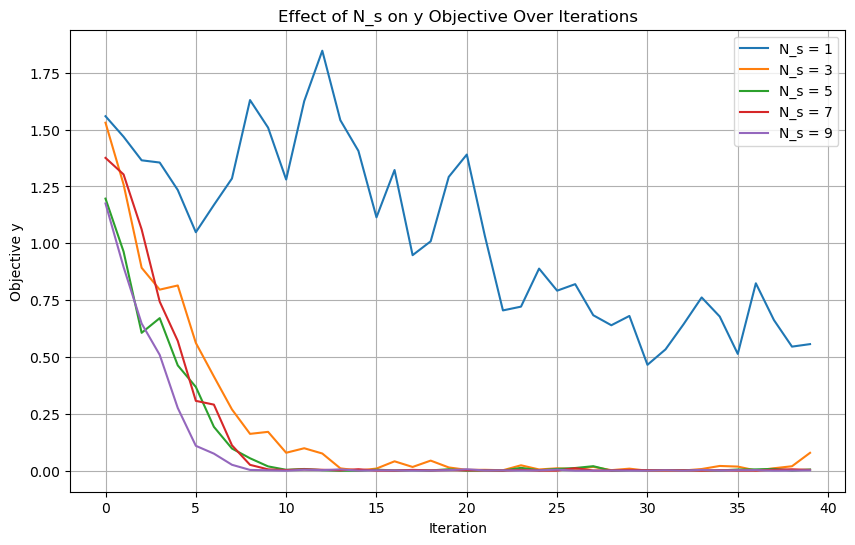

In [25]:
# Plot the results
plt.figure(figsize=(10, 6))
for N_s, y in results.items():
    plt.plot(range(optim_steps), y, label=f"N_s = {N_s}")

plt.xlabel("Iteration")
plt.ylabel("Objective y")
plt.title("Effect of N_s on y Objective Over Iterations")
plt.legend()
plt.grid(True)
plt.show()


Step 1/40
Epoch 0: Total Loss=5.5168
Epoch 1: Total Loss=5.5034
Epoch 2: Total Loss=5.4916
Epoch 3: Total Loss=5.4800
Epoch 4: Total Loss=5.4683
Epoch 5: Total Loss=5.4575
Epoch 6: Total Loss=5.4463
Epoch 7: Total Loss=5.4342
Epoch 8: Total Loss=5.4267
Epoch 9: Total Loss=5.4160
Updated x: [0.7924132943153381, -0.7985142469406128], Function Value: 1.265543818473816, Gradient: [-0.030707500874996185, -0.009736382402479649]

Step 2/40
Epoch 0: Total Loss=3.1871
Epoch 1: Total Loss=3.1776
Epoch 2: Total Loss=3.1703
Epoch 3: Total Loss=3.1623
Epoch 4: Total Loss=3.1534
Epoch 5: Total Loss=3.1480
Epoch 6: Total Loss=3.1376
Epoch 7: Total Loss=3.1294
Epoch 8: Total Loss=3.1198
Epoch 9: Total Loss=3.1121
Updated x: [0.8656539916992188, -0.6741025447845459], Function Value: 1.2037711143493652, Gradient: [-0.03291081637144089, -0.014611996710300446]

Step 3/40
Epoch 0: Total Loss=3.1460
Epoch 1: Total Loss=3.1362
Epoch 2: Total Loss=3.1275
Epoch 3: Total Loss=3.1196
Epoch 4: Total Loss=3.1088


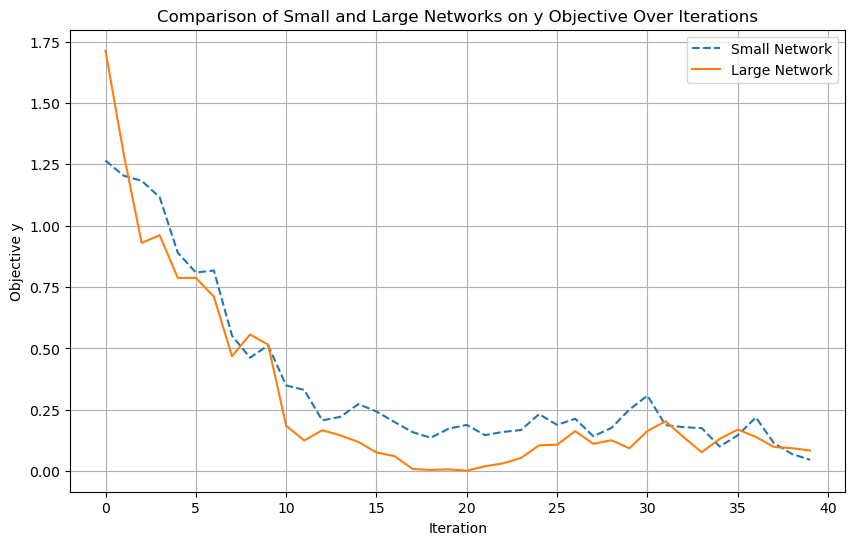

In [26]:
# Define the number of optimization steps
optim_steps = 40
N_s = 2  # Keep N_s constant

# Dictionary to store results
results = {}

# Small network
old_dataset = OldDataSet(data, k=10)
new_dataset = NewDataSet(k=10)
model_small = MLP(2, [5, 5, 5], 1)  # Original network

x_path_small, y_path_small = optimize_surrogate_model(
    model_small, old_dataset, new_dataset, assSim, 
    optim_steps=optim_steps, N_s=N_s, lr=0.001, merge_interval=10
)

results["Small Network"] = y_path_small

# Large network (quadrupled neurons)
model_large = MLP(2, [20, 20, 20], 1)  # Quadrupled neurons

x_path_large, y_path_large = optimize_surrogate_model(
    model_large, old_dataset, new_dataset, assSim, 
    optim_steps=optim_steps, N_s=N_s, lr=0.001, merge_interval=10
)

results["Large Network"] = y_path_large

# Plot the results
plt.figure(figsize=(10, 6))

plt.plot(range(optim_steps), results["Small Network"], linestyle="--", label="Small Network")
plt.plot(range(optim_steps), results["Large Network"], linestyle="-", label="Large Network")

plt.xlabel("Iteration")
plt.ylabel("Objective y")
plt.title("Comparison of Small and Large Networks on y Objective Over Iterations")
plt.legend()
plt.grid(True)
plt.show()



Step 1/40
Epoch 0: Total Loss=1.6477
Epoch 1: Total Loss=1.6225
Epoch 2: Total Loss=1.5974
Epoch 3: Total Loss=1.5725
Epoch 4: Total Loss=1.5478
Epoch 5: Total Loss=1.5233
Epoch 6: Total Loss=1.4989
Epoch 7: Total Loss=1.4748
Epoch 8: Total Loss=1.4509
Epoch 9: Total Loss=1.4272
Updated x: [0.7157641053199768, -0.8853240013122559], Function Value: 1.296116828918457, Gradient: [0.5974026322364807, -0.8388539552688599]

Step 2/40
Epoch 0: Total Loss=1.3524
Epoch 1: Total Loss=1.3304
Epoch 2: Total Loss=1.3087
Epoch 3: Total Loss=1.2874
Epoch 4: Total Loss=1.2664
Epoch 5: Total Loss=1.2458
Epoch 6: Total Loss=1.2257
Epoch 7: Total Loss=1.2059
Epoch 8: Total Loss=1.1866
Epoch 9: Total Loss=1.1678
Updated x: [0.6643960475921631, -1.002299189567566], Function Value: 1.4460257291793823, Gradient: [0.7353987097740173, -0.9973020553588867]

Step 3/40
Epoch 0: Total Loss=1.1495
Epoch 1: Total Loss=1.2463
Epoch 2: Total Loss=1.1137
Epoch 3: Total Loss=1.2108
Epoch 4: Total Loss=1.0800
Epoch 5: T

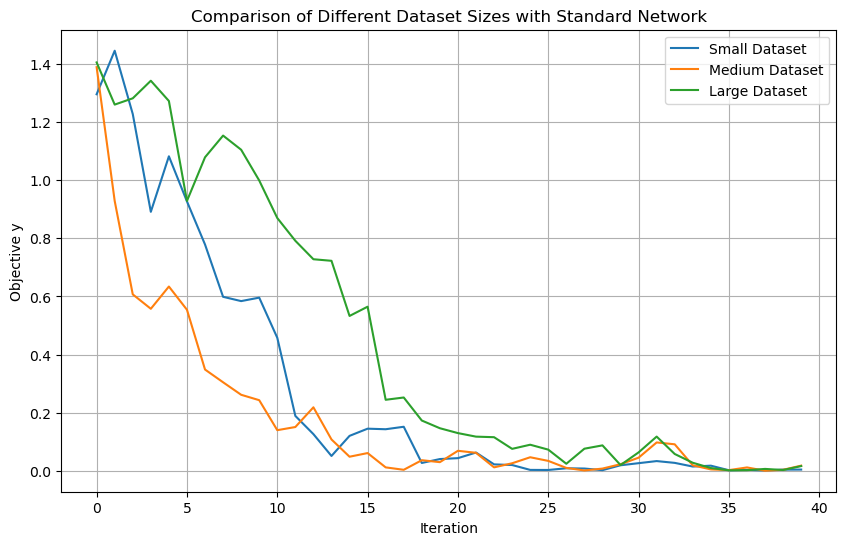

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of optimization steps
optim_steps = 40
N_s = 2  # Keep N_s constant

# Define dataset sizes
datasets = {
    "Small Dataset": data_small,
    "Medium Dataset": data,  # Default dataset
    "Large Dataset": data_big
}

# Dictionary to store results
results = {}

# Loop over dataset sizes
for dataset_name, dataset in datasets.items():
    old_dataset = OldDataSet(dataset, k=10)
    new_dataset = NewDataSet(k=10)
    model = MLP(2, [5, 5, 5], 1)  # Standard network size

    # Run optimization
    _, y_path = optimize_surrogate_model(
        model, old_dataset, new_dataset, assSim, 
        optim_steps=optim_steps, N_s=N_s, lr=0.001, merge_interval=10
    )

    # Store results
    results[dataset_name] = y_path

# Plot the results
plt.figure(figsize=(10, 6))

for dataset_name in datasets.keys():
    plt.plot(range(optim_steps), results[dataset_name], label=f"{dataset_name}")

plt.xlabel("Iteration")
plt.ylabel("Objective y")
plt.title("Comparison of Different Dataset Sizes with Standard Network")
plt.legend()
plt.grid(True)
plt.show()



Step 1/200
Epoch 0: Total Loss=84272.9766
Epoch 1: Total Loss=84218.4180
Epoch 2: Total Loss=84164.5352
Epoch 3: Total Loss=84111.2227
Epoch 4: Total Loss=84058.3984
Epoch 5: Total Loss=84005.9570
Epoch 6: Total Loss=83953.9062
Epoch 7: Total Loss=83902.1953
Epoch 8: Total Loss=83850.8633
Epoch 9: Total Loss=83799.9336
Updated x: [10.074095726013184, -10.089149475097656], Function Value: 203.27835083007812, Gradient: [-0.14141641557216644, -0.0008042083354666829]

Step 2/200
Epoch 0: Total Loss=83448.0664
Epoch 1: Total Loss=83397.4883
Epoch 2: Total Loss=83347.2578
Epoch 3: Total Loss=83418.9805
Epoch 4: Total Loss=83247.7266
Epoch 5: Total Loss=83198.3477
Epoch 6: Total Loss=83149.1953
Epoch 7: Total Loss=83221.8164
Epoch 8: Total Loss=83051.1680
Epoch 9: Total Loss=83002.1172
Updated x: [10.02176284790039, -10.113715171813965], Function Value: 202.72296142578125, Gradient: [-0.12135874480009079, -0.030062247067689896]

Step 3/200
Epoch 0: Total Loss=81861.8555
Epoch 1: Total Loss=8

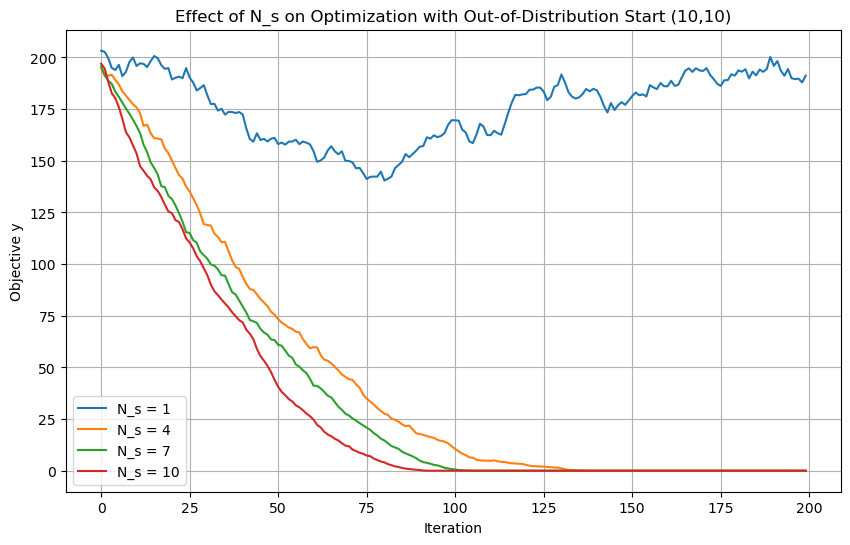

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of optimization steps
optim_steps = 200

# Define the range of N_s values
N_s_values = np.arange(1, 11,3)  # N_s from 1 to 10

# Define dataset
dataset = data  # Using only the standard dataset

# Dictionary to store results
results = {}

# Loop over N_s values
for N_s in N_s_values:
    old_dataset = OldDataSet(dataset, k=10)
    new_dataset = NewDataSet(k=10)
    model = MLP(2, [5, 5, 5], 1)  # Standard network size

    # Set an out-of-distribution starting point
    x_start = torch.tensor([10, -10], dtype=torch.float32, requires_grad=True)

    # Run optimization
    _, y_path = optimize_surrogate_model(
        model, old_dataset, new_dataset, assSim, 
        optim_steps=optim_steps, N_s=N_s, lr=0.001, merge_interval=10, x_init=x_start
    )

    # Store results
    results[N_s] = y_path

# Plot the results
plt.figure(figsize=(10, 6))

for N_s in N_s_values:
    plt.plot(range(optim_steps), results[N_s], label=f"N_s = {N_s}")

plt.xlabel("Iteration")
plt.ylabel("Objective y")
plt.title("Effect of N_s on Optimization with Out-of-Distribution Start (10,10)")
plt.legend()
plt.grid(True)
plt.show()
